In [1]:
import kagglehub
import shutil
import os

if os.path.isdir("/content/data"):
    shutil.rmtree("/content/data")

# Download latest version
path = kagglehub.dataset_download("ammaralfaifi/5class-weather-status-image-classification")
path = path + '/data'

shutil.copytree(path, "/content/data", dirs_exist_ok=True)
path = "/content/data"

print("Path to dataset files:", path)

Using Colab cache for faster access to the '5class-weather-status-image-classification' dataset.
Path to dataset files: /content/data


In [2]:
import os

classes = os.listdir(path)

for img_class in classes:
  print(img_class, len(os.listdir(path + '/' + img_class)))

cloudy 6702
snowy 1875
sunny 6274
foggy 1261
rainy 1927


In [3]:
# Data Augmentation
import tensorflow as tf
import cv2

minority_classes = ['rainy', 'snowy', 'foggy']

def augment_image_flip(image):
  image = tf.image.random_flip_left_right(image)
  return image

def augment_image_lighting(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

for minority in minority_classes:
  for img_path in os.listdir(path + '/' + minority):
    full_path = path + '/' + minority + '/' + img_path
    img = cv2.imread(full_path)
    flipped_img = augment_image_flip(img)
    lighting_img = augment_image_lighting(img)
    cv2.imwrite(path + '/' + minority + '/flipped_' + img_path, flipped_img.numpy())
    cv2.imwrite(path + '/' + minority + '/lighting_' + img_path, lighting_img.numpy())


In [4]:
for img_class in classes:
  print(img_class, len(os.listdir(path + '/' + img_class)))

cloudy 6702
snowy 5625
sunny 6274
foggy 3783
rainy 5781


In [5]:
# Augment foggy images a bit more
minority_classes = ['foggy']

for minority in minority_classes:
  for img_path in os.listdir(path + '/' + minority):
    if img_path.startswith('flipped_'):
      full_path = path + '/' + minority + '/' + img_path
      img = cv2.imread(full_path)
      lighting_img = augment_image_lighting(img)
      cv2.imwrite(path + '/' + minority + '/lighting_' + img_path, lighting_img.numpy())


In [6]:
for img_class in classes:
  print(img_class, len(os.listdir(path + '/' + img_class)))

cloudy 6702
snowy 5625
sunny 6274
foggy 5044
rainy 5781


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<a id="1"></a>
## Loading the Data Set
* In this part we load and visualize the data.

In [8]:
#del x
#del y
#del X_train
#del X_test
#del Y_train
#del Y_test
x, y = [], []
for i, img_class in enumerate(classes):
  print(img_class + " Loading...")
  class_path = path + '/' + img_class
  for j, img_name in enumerate(os.listdir(class_path)):
    if j == 1600:
      break
    img_path = class_path + '/' + img_name
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    x.append(img)
    y.append(i)

x, y = np.array(x), np.array(y)

cloudy Loading...
snowy Loading...
sunny Loading...
foggy Loading...
rainy Loading...


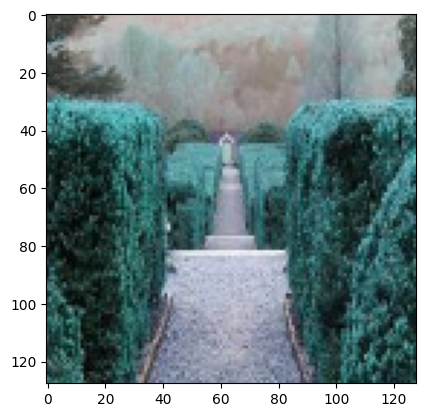

In [9]:
plt.imshow(x[0])

In [10]:
# Normalize the data
x = x / 255.0
x[0]

array([[[0.23529412, 0.26666667, 0.25490196],
        [0.23921569, 0.2627451 , 0.25098039],
        [0.2627451 , 0.27843137, 0.27058824],
        ...,
        [0.45490196, 0.50980392, 0.48627451],
        [0.37647059, 0.42745098, 0.40392157],
        [0.3372549 , 0.38431373, 0.36078431]],

       [[0.30196078, 0.3254902 , 0.30588235],
        [0.25098039, 0.2745098 , 0.25490196],
        [0.21568627, 0.23529412, 0.21960784],
        ...,
        [0.32941176, 0.38431373, 0.36078431],
        [0.42745098, 0.48235294, 0.45882353],
        [0.45490196, 0.50196078, 0.47843137]],

       [[0.31372549, 0.33333333, 0.31372549],
        [0.32941176, 0.35294118, 0.32941176],
        [0.24705882, 0.2627451 , 0.24313725],
        ...,
        [0.35294118, 0.40784314, 0.38431373],
        [0.32156863, 0.37254902, 0.34901961],
        [0.41176471, 0.45882353, 0.43529412]],

       ...,

       [[0.19215686, 0.36078431, 0.36862745],
        [0.03529412, 0.17647059, 0.17647059],
        [0.14509804, 0

<a id="3"></a>
## Train Test Split
* We split the data into train and test sets.
* test size is 10%.
* train size is 90%.

In [11]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_test.shape)


x_train shape (7200, 128, 128, 3)
x_test shape (800, 128, 128, 3)
y_train shape (7200,)
y_test shape (800,)


In [12]:
del x
del y

<a id="10"></a>
## Implementing with Keras

In [13]:

import tensorflow as tf
import os,random
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D, Activation, BatchNormalization

from tensorflow.keras.optimizers import RMSprop,Adam

model = Sequential()
model.add(Input((128, 128, 3)))

# --- Block 1 (2 Conv Layers) ---
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# --- Block 2 (2 Conv Layers) ---
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# --- Block 3 (4 Conv Layers) ---
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# --- Block 4 (4 Conv Layers) ---
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# --- Block 5 (4 Conv Layers) ---
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# --- Classification Head ---
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,02

 Total params: 24,506,437 (93.48 MB)

 Trainable params: 24,495,429 (93.44 MB)

 Non-trainable params: 11,008 (43.00 KB)

<a id="12"></a>
### Define Optimizer   
* Adam optimizer: Change the learning rate


In [14]:
# Define the optimizer
optimizer = Adam(learning_rate=0.00001)

In [15]:
# Compile the model
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [16]:
epochs = 10  # for better result increase the epochs
batch_size = 32

In [17]:
# Fit the model
history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, Y_test))


Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 91s 245ms/step - accuracy: 0.3050 - loss: 2.0040 - val_accuracy: 0.1963 - val_loss: 2.6121
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 54s 241ms/step - accuracy: 0.4450 - loss: 1.3530 - val_accuracy: 0.2375 - val_loss: 1.9004
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - accuracy: 0.5006 - loss: 1.2046 - val_accuracy: 0.6237 - val_loss: 1.0196
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 246ms/step - accuracy: 0.5729 - loss: 1.0795 - val_accuracy: 0.6500 - val_loss: 0.9462
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - accuracy: 0.5920 - loss: 1.0142 - val_accuracy: 0.6500 - val_loss: 0.9344
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - accuracy: 0.6146 - loss: 0.9728 - val_accuracy: 0.6800 - val_loss: 0.8784
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 247ms/step - accuracy: 0.6347 - loss: 0.9426 - val_accuracy: 0.6925 - val_loss: 0.8384
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - accuracy: 0.6632 - loss: 0

<a id="17"></a>
### Evaluate the model
* Test Loss visualization
* Confusion matrix


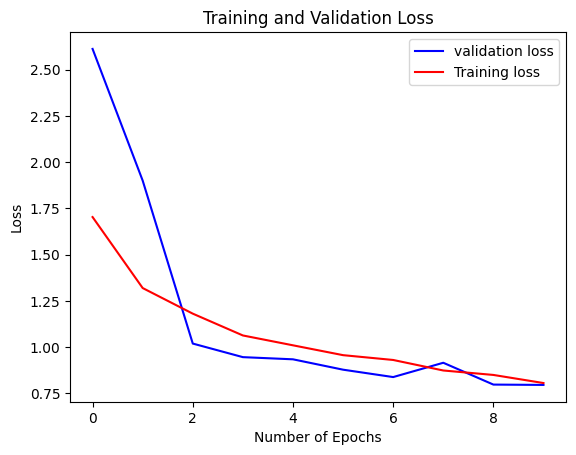

In [18]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="Training loss")
plt.title("Training and Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

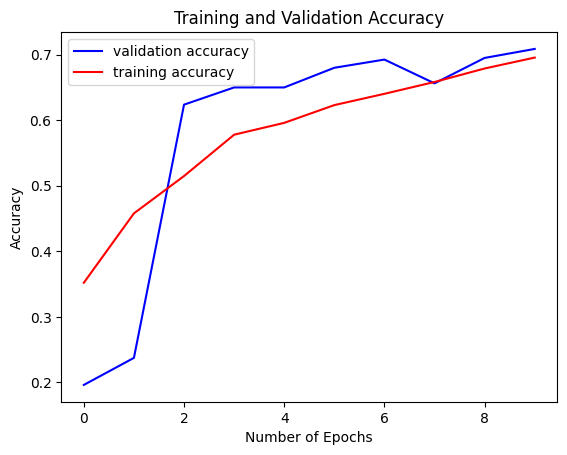

In [19]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="training accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Predictions
predictions = model.predict(X_test)
# get the class with the highest probability
Y_pred = np.argmax(predictions, axis=1)

# Metrics
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Precision:", precision_score(Y_test, Y_pred, average='weighted'))
print("Recall:", recall_score(Y_test, Y_pred, average='weighted'))
print("F1-score:", f1_score(Y_test, Y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(Y_test, Y_pred, target_names=classes))


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
Accuracy: 0.70875
Precision: 0.7086865250921646
Recall: 0.70875
F1-score: 0.7050291159259966

Confusion Matrix:
 [[ 76  11  21  10  40]
 [  6 121   6   6  20]
 [ 10   6 126   3  11]
 [  6   5   1 135  10]
 [ 16  29   9   7 109]]

Classification Report:

              precision    recall  f1-score   support

      cloudy       0.67      0.48      0.56       158
       snowy       0.70      0.76      0.73       159
       sunny       0.77      0.81      0.79       156
       foggy       0.84      0.86      0.85       157
       rainy       0.57      0.64      0.61       170

    accuracy                           0.71       800
   macro avg       0.71      0.71      0.71       800
weighted avg       0.71      0.71      0.71       800

